<a href="https://colab.research.google.com/github/Lydia-Ye/clinical_notes_scoring_llm/blob/main/Clinical_Text_to_Score_LLM_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# installs the updated Hugging Face libraries required to load Qwen3 on GPU and handle model weights efficiently
!pip -q install -U "transformers>=4.51.0" accelerate safetensors


In [3]:
# log in to hugging face
from huggingface_hub import login
from google.colab import userdata

token = userdata.get("HF_TOKEN")  # pulled from Colab Secrets if you set it
if token:
    login(token=token)
    print("Logged in to Hugging Face")
else:
    print("No HF_TOKEN found in Colab Secrets. You can still try loading public models.")


Logged in to Hugging Face


In [4]:
# load qwen3
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

MODEL_NAME = "Qwen/Qwen3-0.6B"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True,
)
model.eval()

print("Loaded", MODEL_NAME, "on", model.device)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Loaded Qwen/Qwen3-0.6B on cuda:0


In [5]:
# qwen3 generation wrapper
import re, random, math
import numpy as np
import torch

def qwen3_generate(user_msg, max_new_tokens=128, temperature=0.0):
    messages = [{"role": "user", "content": user_msg}]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
        enable_thinking=False,
    )
    inputs = tokenizer([text], return_tensors="pt").to(model.device)

    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=(temperature > 0),
            temperature=temperature,
        )

    decoded = tokenizer.decode(out[0], skip_special_tokens=True)
    return decoded

def strip_think(text: str) -> str:
    return re.sub(r"<think>.*?</think>", "", text, flags=re.DOTALL).strip()

def extract_score(text: str):
    """Extract the last number in model output; return None if no number."""
    text = strip_think(text)
    nums = re.findall(r"[-+]?\d*\.\d+|[-+]?\d+", text)
    return float(nums[-1]) if nums else None

# test
print(strip_think(qwen3_generate("Return only the number 3.")))



The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


user
Return only the number 3.
assistant


3


In-context learning demo with two actual examples from proposal

* Extracts assistance levels from clinical notes and maps assistance levels to numeric scores
* Tests with k=0 (zero-shot) vs k=2 (two examples) in-context learning on five test cases

In [ ]:
# update qwen3 prompt
import json, re, random

# EDIT THIS to match your scoring exactly
RUBRIC = {
  "Total Assist": 1,
  "Maximal Assist": 2,
  "Moderate Assist": 3,
  "Minimal Assist": 3,
  "Supervision/Touching Assist": 4,
  "Independent": 6,
  "Unknown": None
}

ALLOWED_LEVELS = list(RUBRIC.keys())

def build_scoring_prompt(note_text, k_examples=None):
    examples_str = ""
    if k_examples:
        for i, ex in enumerate(k_examples, 1):
            examples_str += (
                f"Example {i} NOTE:\n{ex['note']}\n\n"
                f"Example {i} OUTPUT JSON:\n{json.dumps(ex['gold_json'], ensure_ascii=False)}\n\n"
            )

    instruction = f"""
You are an occupational therapy scoring assistant.

TASK:
1) From the NOTE, extract the assistance level for each item:
- Dressing (UB/LB)
- Bathing
- Eating/Self-Feeding
- Toileting Hygiene
- Oral Hygiene
- Grooming

2) Convert each assistance level to a numeric score using this rubric:
{json.dumps(RUBRIC, ensure_ascii=False)}

RULES:
- Allowed assistance levels are exactly: {ALLOWED_LEVELS}
- If the note does not mention an item, use "Unknown" and score null.
- Return ONLY valid JSON (no markdown, no extra text).
- Include an "evidence" field per item (short phrase copied from note).
- total_self_care_score = sum of six scores ONLY if none are null, else null.

OUTPUT JSON SCHEMA:
{{
  "dressing": {{"level": "...", "score": <number|null>, "evidence": "..."}},
  "bathing":  {{"level": "...", "score": <number|null>, "evidence": "..."}},
  "eating":   {{"level": "...", "score": <number|null>, "evidence": "..."}},
  "toileting_hygiene": {{"level": "...", "score": <number|null>, "evidence": "..."}},
  "oral_hygiene": {{"level": "...", "score": <number|null>, "evidence": "..."}},
  "grooming": {{"level": "...", "score": <number|null>, "evidence": "..."}},
  "total_self_care_score": <number|null>
}}
"""
    return instruction.strip() + "\n\n" + examples_str + "\nNOTE:\n" + note_text


In [ ]:
gold_examples = [
  {
    "note": """Bathing Upper Extremity: Minimal Assist
Bathing Lower Extremity: Minimal Assist
Dressing Upper Extremity: Maximal Assist
Dressing Lower Extremity: Maximal Assist
Eating/Self-Feeding: Independent
Grooming: Moderate Assist
Toileting: Minimal Assist
""",
    "gold_json": {
      "dressing": {"level": "Maximal Assist", "score": 2, "evidence": "Dressing Upper Extremity: Maximal Assist"},
      "bathing": {"level": "Minimal Assist", "score": 3, "evidence": "Bathing Upper Extremity: Minimal Assist"},
      "eating": {"level": "Independent", "score": 6, "evidence": "Eating/Self-Feeding: Independent"},
      "toileting_hygiene": {"level": "Minimal Assist", "score": 3, "evidence": "Toileting: Minimal Assist"},
      "oral_hygiene": {"level": "Unknown", "score": None, "evidence": "Not mentioned"},
      "grooming": {"level": "Moderate Assist", "score": 3, "evidence": "Grooming: Moderate Assist"},
      "total_self_care_score": None
    }
  }
]

gold_examples.append(
  {
    "note": """Dressing Upper Extremity: Moderate Assist
Dressing Lower Extremity: Moderate Assist
Bathing: Minimal Assist
Eating/Self-Feeding: Independent
Toileting Hygiene: Minimal Assist
Oral Hygiene: Supervision/Touching Assist
Grooming: Supervision/Touching Assist
""",
    "gold_json": {
      "dressing": {
        "level": "Moderate Assist",
        "score": 3,
        "evidence": "Dressing Upper Extremity: Moderate Assist"
      },
      "bathing": {
        "level": "Minimal Assist",
        "score": 3,
        "evidence": "Bathing: Minimal Assist"
      },
      "eating": {
        "level": "Independent",
        "score": 6,
        "evidence": "Eating/Self-Feeding: Independent"
      },
      "toileting_hygiene": {
        "level": "Minimal Assist",
        "score": 3,
        "evidence": "Toileting Hygiene: Minimal Assist"
      },
      "oral_hygiene": {
        "level": "Supervision/Touching Assist",
        "score": 4,
        "evidence": "Oral Hygiene: Supervision/Touching Assist"
      },
      "grooming": {
        "level": "Supervision/Touching Assist",
        "score": 4,
        "evidence": "Grooming: Supervision/Touching Assist"
      },
      "total_self_care_score": 23
    }
  }
)




In [ ]:

def extract_json_from_fence(text):
    text = re.sub(r"<think>.*?</think>", "", text, flags=re.DOTALL)

    # Prefer a ```json ... ``` block if present
    m = re.search(r"```json\s*(\{.*?\})\s*```", text, flags=re.DOTALL)
    if m:
        try:
            return json.loads(m.group(1))
        except:
            return None

    # Fallback: try any {...} block (last one usually is the answer)
    candidates = re.findall(r"\{.*?\}", text, flags=re.DOTALL)
    for cand in reversed(candidates):
        try:
            return json.loads(cand)
        except:
            continue
    return None


In [ ]:
note_text = """Bathing Upper Extremity: Minimal Assist
Bathing Lower Extremity: Minimal Assist
Dressing Upper Extremity: Maximal Assist
Dressing Lower Extremity: Maximal Assist
Eating/Self-Feeding: Independent
Grooming: Moderate Assist
Toileting: Minimal Assist
"""


prompt = build_scoring_prompt(note_text, k_examples=gold_examples)
raw = qwen3_generate(prompt, max_new_tokens=400, temperature=0.0)

obj = extract_json_from_fence(raw)
print(obj)



{'dressing': {'level': 'Maximal Assist', 'score': 2, 'evidence': 'Dressing Upper Extremity: Maximal Assist'}, 'bathing': {'level': 'Minimal Assist', 'score': 3, 'evidence': 'Bathing Upper Extremity: Minimal Assist'}, 'eating': {'level': 'Independent', 'score': 6, 'evidence': 'Eating/Self-Feeding: Independent'}, 'toileting_hygiene': {'level': 'Minimal Assist', 'score': 3, 'evidence': 'Toileting: Minimal Assist'}, 'oral_hygiene': {'level': 'Unknown', 'score': None, 'evidence': 'Not mentioned'}, 'grooming': {'level': 'Moderate Assist', 'score': 3, 'evidence': 'Grooming: Moderate Assist'}, 'total_self_care_score': 23}


In [ ]:
# compute total score
ITEMS = ["dressing", "bathing", "eating", "toileting_hygiene", "oral_hygiene", "grooming"]

def compute_total(obj):
    if obj is None:
        return None
    scores = []
    for item in ITEMS:
        s = obj.get(item, {}).get("score", None)
        if s is None:
            return None
        scores.append(float(s))
    return sum(scores)

def add_total(obj):
    if obj is None:
        return None
    obj = dict(obj)  # shallow copy
    obj["total_self_care_score"] = compute_total(obj)
    return obj

print(add_total({'dressing': {'score': 2}, 'bathing': {'score': 3}, 'eating': {'score': 6},
                 'toileting_hygiene': {'score': 3}, 'oral_hygiene': {'score': 3}, 'grooming': {'score': 3}}))


{'dressing': {'score': 2}, 'bathing': {'score': 3}, 'eating': {'score': 6}, 'toileting_hygiene': {'score': 3}, 'oral_hygiene': {'score': 3}, 'grooming': {'score': 3}, 'total_self_care_score': 20.0}


In [ ]:
note_complete = """Bathing Upper Extremity: Minimal Assist
Bathing Lower Extremity: Minimal Assist
Dressing Upper Extremity: Maximal Assist
Dressing Lower Extremity: Maximal Assist
Eating/Self-Feeding: Independent
Toileting: Minimal Assist
Oral Hygiene: Moderate Assist
Grooming: Moderate Assist
"""

prompt = build_scoring_prompt(note_complete, k_examples=gold_examples)
raw = qwen3_generate(prompt, max_new_tokens=400, temperature=0.0)
obj = extract_json_from_fence(raw)
obj2 = add_total(obj)

print("PARSED:", obj2)


PARSED: {'dressing': {'level': 'Maximal Assist', 'score': 2, 'evidence': 'Dressing Upper Extremity: Maximal Assist'}, 'bathing': {'level': 'Minimal Assist', 'score': 3, 'evidence': 'Bathing Upper Extremity: Minimal Assist'}, 'eating': {'level': 'Independent', 'score': 6, 'evidence': 'Eating/Self-Feeding: Independent'}, 'toileting_hygiene': {'level': 'Minimal Assist', 'score': 3, 'evidence': 'Toileting: Minimal Assist'}, 'oral_hygiene': {'level': 'Moderate Assist', 'score': 3, 'evidence': 'Oral Hygiene: Moderate Assist'}, 'grooming': {'level': 'Moderate Assist', 'score': 3, 'evidence': 'Grooming: Moderate Assist'}, 'total_self_care_score': 20.0}


In [ ]:
test_notes = [
  # -------- Test note 1: mostly independent --------
  {
    "note": """Dressing Upper Extremity: Independent
Dressing Lower Extremity: Independent
Bathing: Supervision/Touching Assist
Eating/Self-Feeding: Independent
Toileting Hygiene: Independent
Oral Hygiene: Independent
Grooming: Independent
""",
    "gold_levels": {
      "dressing": "Independent",
      "bathing": "Supervision/Touching Assist",
      "eating": "Independent",
      "toileting_hygiene": "Independent",
      "oral_hygiene": "Independent",
      "grooming": "Independent",
    }
  },

  # -------- Test note 2: heavy assistance --------
  {
    "note": """Dressing Upper Extremity: Maximal Assist
Dressing Lower Extremity: Maximal Assist
Bathing: Maximal Assist
Eating/Self-Feeding: Moderate Assist
Toileting Hygiene: Maximal Assist
Oral Hygiene: Moderate Assist
Grooming: Moderate Assist
""",
    "gold_levels": {
      "dressing": "Maximal Assist",
      "bathing": "Maximal Assist",
      "eating": "Moderate Assist",
      "toileting_hygiene": "Maximal Assist",
      "oral_hygiene": "Moderate Assist",
      "grooming": "Moderate Assist",
    }
  },

  # -------- Test note 3: mixed levels --------
  {
    "note": """Dressing Upper Extremity: Moderate Assist
Dressing Lower Extremity: Minimal Assist
Bathing: Minimal Assist
Eating/Self-Feeding: Independent
Toileting Hygiene: Minimal Assist
Oral Hygiene: Supervision/Touching Assist
Grooming: Supervision/Touching Assist
""",
    "gold_levels": {
      "dressing": "Moderate Assist",
      "bathing": "Minimal Assist",
      "eating": "Independent",
      "toileting_hygiene": "Minimal Assist",
      "oral_hygiene": "Supervision/Touching Assist",
      "grooming": "Supervision/Touching Assist",
    }
  },

  # -------- Test note 4: plateaued / vague wording --------
  {
    "note": """Dressing Upper Extremity: Moderate Assist
Dressing Lower Extremity: Moderate Assist
Bathing: Minimal Assist
Eating/Self-Feeding: Independent
Toileting Hygiene: Minimal Assist
Oral Hygiene: Minimal Assist
Grooming: Minimal Assist
""",
    "gold_levels": {
      "dressing": "Moderate Assist",
      "bathing": "Minimal Assist",
      "eating": "Independent",
      "toileting_hygiene": "Minimal Assist",
      "oral_hygiene": "Minimal Assist",
      "grooming": "Minimal Assist",
    }
  },

  # -------- Test note 5: asymmetric function --------
  {
    "note": """Dressing Upper Extremity: Moderate Assist
Dressing Lower Extremity: Maximal Assist
Bathing: Moderate Assist
Eating/Self-Feeding: Independent
Toileting Hygiene: Moderate Assist
Oral Hygiene: Supervision/Touching Assist
Grooming: Moderate Assist
""",
    "gold_levels": {
      "dressing": "Moderate Assist",
      "bathing": "Moderate Assist",
      "eating": "Independent",
      "toileting_hygiene": "Moderate Assist",
      "oral_hygiene": "Supervision/Touching Assist",
      "grooming": "Moderate Assist",
    }
  }
]



In [ ]:
def score_one(note_text, k_examples):
    prompt = build_scoring_prompt(note_text, k_examples=k_examples)
    raw = qwen3_generate(prompt, max_new_tokens=400, temperature=0.0)
    obj = extract_json_from_fence(raw)
    obj = add_total(obj)
    return obj

def eval_notes(test_notes, k_examples):
    total_items = 0
    correct_levels = 0

    for ex in test_notes:
        pred = score_one(ex["note"], k_examples=k_examples)
        if pred is None:
            continue

        for item, gold_level in ex["gold_levels"].items():
            total_items += 1
            if pred.get(item, {}).get("level") == gold_level:
                correct_levels += 1

    acc = correct_levels / total_items if total_items else 0.0
    return acc

print("k=0 acc:", eval_notes(test_notes, k_examples=None))
print("k=2 acc:", eval_notes(test_notes, k_examples=gold_examples))


ValueError: could not convert string to float: 'Moderate Assist'

In-context learning demo with synthetic regression dataset
* Dataset: Generates 120 synthetic clinical notes (80 train, 40 test) with patient features (age, grip strength, pain, fatigue) → recovery scores (0-100)
* Prompt: Uses varying numbers of in-context examples (k=0,2,4,8,12) to predict recovery scores
* Evaluation Metric: Mean Absolute Error (MAE)

In [11]:
# create dataset
import random, numpy as np
random.seed(0)
np.random.seed(0)

def clamp(x, lo, hi):
    return max(lo, min(hi, x))

def make_example():
    # Structured features
    age = random.randint(35, 85)
    systolic = random.randint(90, 180)
    grip = random.randint(5, 60)          # strength proxy
    walk_sec = random.randint(8, 60)      # time to walk 10m
    pain = random.randint(0, 10)          # 0-10
    fatigue = random.choice(["low", "moderate", "high"])

    fatigue_num = {"low": 0, "moderate": 1, "high": 2}[fatigue]

    # ----- Ground-truth "your regression model" -----
    # Higher grip, lower walk time, lower pain, lower fatigue => higher score
    y = (
        75
        - 0.35 * (age - 50)
        - 0.25 * (systolic - 120)
        + 0.9  * (grip)
        - 1.1  * (walk_sec)
        - 2.0  * (pain)
        - 4.0  * (fatigue_num)
        + np.random.normal(0, 0.5)        # noise
    )
    score = clamp(y, 0, 100)

    # Turn features into a "note"
    note = (
        f"OT note: Patient age {age}. BP {systolic}/??. "
        f"Grip strength ~{grip}. Walked 10 meters in {walk_sec} seconds. "
        f"Pain {pain}/10. Fatigue: {fatigue}. "
        f"Assessment: functional status documented for rehab."
    )
    return note, float(score)

data = [make_example() for _ in range(120)]
train = data[:80]
test = data[80:]

train[0]


('OT note: Patient age 59. BP 143/??. Grip strength ~7. Walked 10 meters in 24 seconds. Pain 8/10. Fatigue: moderate. Assessment: functional status documented for rehab.',
 26.882026172983817)

In [12]:
# Build k-shot regression prompt

def build_regression_prompt(train_examples, query_note, k):
    shots = random.sample(train_examples, k) if k > 0 else []

    instr = (
        "You are a regression assistant.\n"
        "Predict the patient's recovery score (0 to 100) from the OT note.\n"
        "Return ONLY one number (can be a decimal). No words.\n\n"
    )

    demos = ""
    for i, (note, score) in enumerate(shots, 1):
        demos += f"Example {i}\nNOTE: {note}\nSCORE: {score:.1f}\n\n"

    query = f"Now predict:\nNOTE: {query_note}\nSCORE:"
    return instr + demos + query


In [13]:
def predict_score(note, k):
    prompt = build_regression_prompt(train, note, k=k)
    raw = qwen3_generate(prompt, max_new_tokens=32, temperature=0.0)
    pred = extract_score(raw)  # your existing extractor returns float or None
    if pred is None:
        pred = 50.0
    return float(clamp(pred, 0, 100))

def eval_mae(k, n=25):
    samples = random.sample(test, n)
    preds, trues = [], []
    for note, true in samples:
        preds.append(predict_score(note, k))
        trues.append(true)
    return float(np.mean([abs(p-t) for p, t in zip(preds, trues)]))

for k in [0, 2, 4, 8, 12]:
    print(f"k={k:>2} | MAE={eval_mae(k):.2f}")


k= 0 | MAE=24.70
k= 2 | MAE=24.78
k= 4 | MAE=30.65
k= 8 | MAE=24.11
k=12 | MAE=23.73


Sample output:

k= 0 | MAE=24.70

k= 2 | MAE=24.78

k= 4 | MAE=30.65

k= 8 | MAE=24.11

k=12 | MAE=23.73

There is a non-monotonic relationship between the number of in-context examples and prediction error:

* k small → high variance, unstable

* k medium → best bias–variance balance

* k large → overfitting to prompt examples



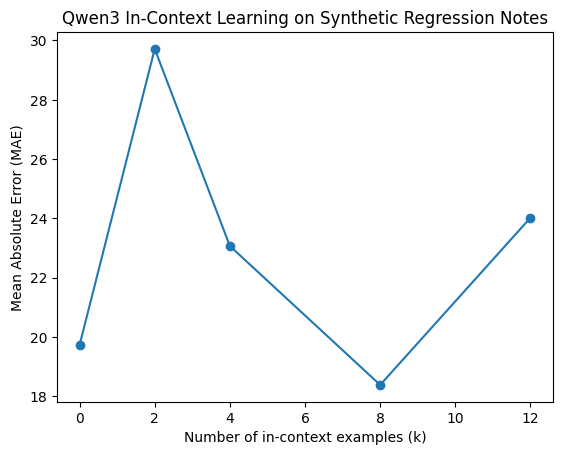

In [15]:
# plot

import matplotlib.pyplot as plt

ks = [0, 2, 4, 8, 12]
maes = [eval_mae(k) for k in ks]

plt.figure()
plt.plot(ks, maes, marker="o")
plt.xlabel("Number of in-context examples (k)")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Qwen3 In-Context Learning on Synthetic Regression Notes")
plt.show()
